In [73]:
import os
import json
import tensorflow as tf
import keras
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
from keras.utils.np_utils import to_categorical
from PIL import ImageColor
from Preprocessing.dataset import listSubFiles, groupPaths

# metadata
NUM_CLASSES = 48
X_TARGET_SHAPE = (256, 256, 1)

# hyperparams
EPOCHS = 100
BATCH_SIZE = 8

# Model definition

In [9]:

def ReduceBlock(inputs, features, dropout=0.3):
    # fmt: off
    conv = tf.keras.layers.Conv2D(features, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(inputs)
    conv = tf.keras.layers.Dropout(dropout)(conv)
    conv = tf.keras.layers.Conv2D(features, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(conv)
    maxp = tf.keras.layers.MaxPool2D((2, 2), strides=(2, 2))(conv)
    # fmt: on
    return conv, maxp


def ExpandBlock(inputs, features, concatenate_with):
    # fmt: off
    upsa = tf.keras.layers.Conv2DTranspose(features, (2, 2), strides=(2, 2), padding="same")(inputs)
    upsa = tf.keras.layers.concatenate([upsa, concatenate_with])
    conv = tf.keras.layers.Conv2D(features, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(upsa)
    conv = tf.keras.layers.Dropout(0.3)(conv)
    conv = tf.keras.layers.Conv2D(features, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(conv)
    # fmt: on
    return upsa, conv


def Unet(num_classes, input_shape=(128, 128, 1)):

    inputs = tf.keras.layers.Input(input_shape)
    bn = tf.keras.layers.BatchNormalization()(inputs)

    # Contraction path
    c1, p1 = ReduceBlock(bn, 16, dropout=0.3)
    c2, p2 = ReduceBlock(p1, 32, dropout=0.3)
    c3, _ = ReduceBlock(p2, 64, dropout=0.3)
    # c4, _ = ReduceBlock(p3, 128, dropout=0.3)

    # Expansion path
    # _, c7 = ExpandBlock(c4, 64, concatenate_with=c3)
    _, c8 = ExpandBlock(c3, 32, concatenate_with=c2)
    _, c9 = ExpandBlock(c8, 16, concatenate_with=c1)

    outputs = tf.keras.layers.Conv2D(num_classes + 1, (1, 1), activation="softmax")(c9)
    return inputs, outputs


tf.keras.backend.clear_session()
inputs, outputs = Unet(NUM_CLASSES, X_TARGET_SHAPE)
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(
    optimizer='adam', loss="categorical_crossentropy", metrics=["accuracy"]
)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 1)  4          ['input_1[0][0]']                
 alization)                                                                                       
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  160         ['batch_normalization[0][0]']    
                                )                                                             

# Dataset

In [3]:
# DATASET_PATH = os.path.join("..", "..", "datasets", "generated", "unet")
DATASET_PATH = os.path.join("..", "..", "datasets", "generated", "unet_aug")

paths = listSubFiles(DATASET_PATH, depth=3)
test, train = groupPaths(paths, 2)
train_x, train_y = groupPaths(train, 1)

# train_y_onehot = [file for file in train_y if file.endswith("_int.png")]
# train_y_multihot = [file for file in train_y if file.endswith(".npy")]

train_x[0], train_y[0]#train_y_onehot[0]#, train_y_multihot[0]

('..\\..\\datasets\\generated\\unet_aug\\train\\x\\0001.png',
 '..\\..\\datasets\\generated\\unet_aug\\train\\y\\0001.png')

In [11]:
class Samples(keras.utils.Sequence):
    def __init__(self, batch_size, img_size, num_classes, x_paths, y_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.x_paths = x_paths
        self.y_paths = y_paths
        self.num_classes = num_classes
    
    def __len__(self):
        return len(self.x_paths)
    
    def __getitem__(self, idx):
        i = idx * self.batch_size
        batch_x_paths = self.x_paths[i:i + self.batch_size]
        batch_y_paths = self.y_paths[i:i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (1,), dtype=np.uint8)
        for j, x_path in enumerate(batch_x_paths):
            x[j] = 255 - cv2.imread(x_path, cv2.IMREAD_GRAYSCALE)[..., None]
        y = np.zeros((self.batch_size,) + self.img_size + (self.num_classes + 1,), dtype=np.uint8)
        # y = np.zeros((self.batch_size,) + self.img_size + (self.num_classes,), dtype=np.float32)
        for j, y_path in enumerate(batch_y_paths):
            # y[j] = np.load(y_path)
            img = cv2.imread(y_path, cv2.IMREAD_GRAYSCALE)
            y[j] = to_categorical(img, self.num_classes + 1)
        return x, y
        

In [12]:
random.Random(1337).shuffle(train_x)
random.Random(1337).shuffle(train_y)

val_split = 0.1
n_valid = int(val_split * len(train_x))
n_train = len(train_x) - n_valid

train_gen = Samples(1, (256, 256), 48, train_x[:n_train], train_y[:n_train])
valid_gen = Samples(1, (256, 256), 48, train_x[n_train:], train_y[n_train:])

((1, 256, 256, 1),
 (1, 256, 256, 49),
 dtype('uint8'),
 dtype('uint8'),
 '..\\..\\datasets\\generated\\unet_aug\\train\\x\\5370.png')

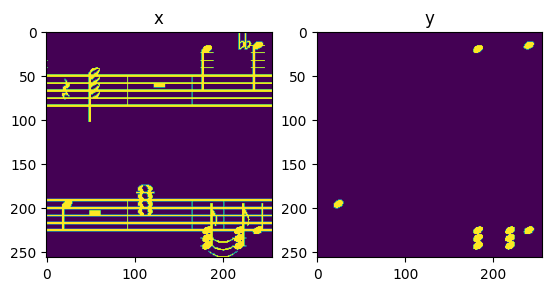

In [13]:
x, y = train_gen.__getitem__(0)

y_vis = np.any(y[0] > 0, axis=2)
fig, axs = plt.subplots(1, 2)
axs[0].imshow(x[0])
axs[1].imshow(np.argmax(y[0], axis=2)==8)
# y = cv2.imread('D:/_FH_TRIER/__Master/OMR/datasets/generated/unet_aug/train/y/1581.png', cv2.IMREAD_GRAYSCALE)
# axs[1].imshow(y==8)
axs[0].set_title("x")
axs[1].set_title("y")
x.shape, y.shape, y.dtype, x.dtype, train_x[:n_train][0]

# Training

In [14]:
import json

MODEL_FILENAME = "test9.h5"
# 4 only ideal, many iterations
# 5 augmented
# 6 augmented but not resized
# 7 augmented resized, but with no noise
# 8 correct augmented dataset
# 9 fixed architecture

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=3),
    tf.keras.callbacks.ModelCheckpoint(
        MODEL_FILENAME,
        verbose=1,
        mode="min",
        save_best_only=True,
        monitor="val_loss",
    ),
    tf.keras.callbacks.TensorBoard(),
]

history = model.fit(
    train_gen,
    validation_data=valid_gen,
    verbose=1,
    epochs=EPOCHS,
    callbacks=callbacks,
)

# save history as json for further evaluation
history_filename = '{}_history.json'.format(MODEL_FILENAME)
history_filepath = os.path.join("histories", history_filename)
with open(history_filepath, 'w') as history_json_file:
    json.dump(history.history, history_json_file)


Epoch 1/100
8208/8208 [==============================] - ETA: 0s - loss: 0.1048 - accuracy: 0.9714
Epoch 1: val_loss improved from inf to 0.02776, saving model to test9.h5
8208/8208 [==============================] - 244s 29ms/step - loss: 0.1048 - accuracy: 0.9714 - val_loss: 0.0278 - val_accuracy: 0.9905
Epoch 2/100
8207/8208 [============================>.] - ETA: 0s - loss: 0.0307 - accuracy: 0.9897
Epoch 2: val_loss improved from 0.02776 to 0.01780, saving model to test9.h5
8208/8208 [==============================] - 234s 28ms/step - loss: 0.0307 - accuracy: 0.9897 - val_loss: 0.0178 - val_accuracy: 0.9937
Epoch 3/100
8208/8208 [==============================] - ETA: 0s - loss: 0.0236 - accuracy: 0.9920
Epoch 3: val_loss improved from 0.01780 to 0.01601, saving model to test9.h5
8208/8208 [==============================] - 240s 29ms/step - loss: 0.0236 - accuracy: 0.9920 - val_loss: 0.0160 - val_accuracy: 0.9944
Epoch 4/100
8208/8208 [==============================] - ETA: 0s - l

# Test the model

1/1 [==============================] - 5s 5s/step


array([ 0,  2,  3,  8, 11, 12, 23, 40, 41, 42, 43, 45, 46, 47],
      dtype=int64)

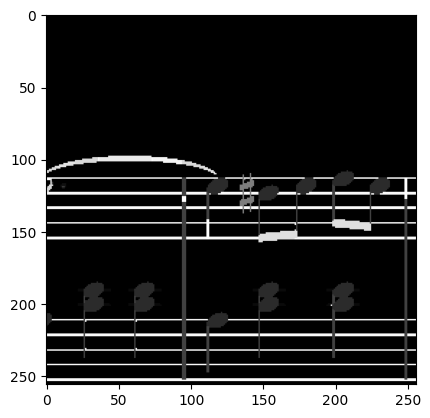

In [34]:
model = tf.keras.models.load_model('test9.h5')

img = cv2.imread("../../datasets/samples/sample_001.png", cv2.IMREAD_GRAYSCALE)
img = np.array((img - np.mean(img)) / np.std(img)).astype(np.uint8)

x, y = 200, 200
pred = model.predict(img[None, x:x+256, y:y+256, None])[0]

plt.imshow(np.argmax(pred, axis=2),cmap="gray")
np.unique(np.argmax(pred, axis=2))
# plt.imshow(pred[..., 11])
# np.mean(pred[..., 13])

8.7491134e-07

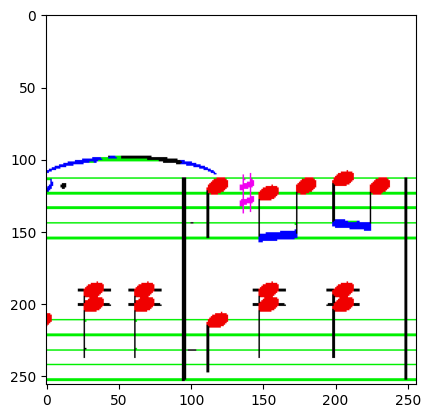

In [32]:
res = 255 - cv2.cvtColor(img[x:x+256, y:y+256, None], cv2.COLOR_GRAY2RGB)

colorings = {
    "#00f000": [46],
    "#0000ff": [41, 42, 40, 29, 30],
    "#f00000": [8],
    # "#f0f000": [29, 30],
    "#f000f0": [28, 23],
}

for color in colorings:
    labels = colorings[color]
    masks = [np.argmax(pred, axis=2)==l for l in labels]
    for mask in masks:
        res[mask] = ImageColor.getcolor(color, 'RGB')
plt.imshow(res)

target_label = 28
# plt.imshow(np.argmax(pred, axis=2)==target_label)
# plt.imshow(pred[..., target_label], cmap="gray")
np.mean(pred[..., target_label])


# Evaluate Model

In [74]:
DATASET_PATH = os.path.join("..", "..", "datasets", "generated", "unet_aug")

# get file paths
paths = listSubFiles(DATASET_PATH, depth=3)
test, train = groupPaths(paths, 2)
test_x, test_y = groupPaths(test, 1)

# obtain classes
df = pd.read_csv('plots/augmented_dataset.csv', sep=";", names=["x", "y", "aug", "classname", "outx", "outy"])

with open('../../datasets/generated/classlist.json', 'r') as file:
    classlist = json.load(file)
    class_mapping = {e["class"]: e["id"] for e in classlist}
    class_mapping_inv = {e["id"]: e["class"] for e in classlist}
len(train), len(test), len(class_mapping)

(18240, 5760, 48)

### Pixel Accuracy

In [78]:
def get_pixel_accuracy(x_path, y_path, classIdx):
    
    # load image files
    sample_x = cv2.imread(x_path, cv2.IMREAD_GRAYSCALE)
    sample_y = cv2.imread(y_path, cv2.IMREAD_GRAYSCALE)

    # normalize input
    sample_x = np.array((sample_x - np.mean(sample_x)) / np.std(sample_x)).astype(np.uint8)

    # predict
    pred_masks = model.predict(sample_x[None, ..., None], verbose=0)[0]
    predicted_classes = np.argmax(pred_masks, axis=-1)

    # Get binary version per class
    pred_binary = predicted_classes == classIdx
    gt_binary = sample_y == classIdx

    # calculate true positive and true negative
    tp = np.sum(pred_binary * gt_binary)
    tn = np.sum((1 - pred_binary) * (1 - gt_binary))

    # calculate false positive and false negative
    fp = np.sum(pred_binary * (1 - gt_binary))
    fn = np.sum((1 - pred_binary) * gt_binary)

    ac = (tp + tn) / (tp + tn + fp + fn)
    return ac

# get a sample
sample = df.loc[7]
get_pixel_accuracy(sample.outx, sample.outy, class_mapping[sample.classname]), sample.classname

(0.999786376953125, 'TimeSig4')

In [79]:
n_test = len(test)
n_classes = len(class_mapping)
accuracies = np.zeros((n_test, n_classes), np.float32)

idx = 0
for x_path, y_path in tqdm(zip(test_x, test_y)):
    for c in range(n_classes):
        accuracies[idx, c-1] = get_pixel_accuracy(x_path, y_path, c)
    idx += 1
np.average(accuracies)

37it [03:37,  6.42s/it]

In [70]:
df.loc[df.apply(lambda x: "test" in x['outx'], axis=1)][['outx', 'outy']]

,outx,outy
912,..\..\datasets\generated\unet_aug\test\x\0001.png,..\..\datasets\generated\unet_aug\test\y\0001.png
913,..\..\datasets\generated\unet_aug\test\x\0002.png,..\..\datasets\generated\unet_aug\test\y\0002.png
914,..\..\datasets\generated\unet_aug\test\x\0003.png,..\..\datasets\generated\unet_aug\test\y\0003.png
915,..\..\datasets\generated\unet_aug\test\x\0004.png,..\..\datasets\generated\unet_aug\test\y\0004.png
916,..\..\datasets\generated\unet_aug\test\x\0005.png,..\..\datasets\generated\unet_aug\test\y\0005.png
...,...,...
11995,..\..\datasets\generated\unet_aug\test\x\2876.png,..\..\datasets\generated\unet_aug\test\y\2876.png
11996,..\..\datasets\generated\unet_aug\test\x\2877.png,..\..\datasets\generated\unet_aug\test\y\2877.png
11997,..\..\datasets\generated\unet_aug\test\x\2878.png,..\..\datasets\generated\unet_aug\test\y\2878.png
11998,..\..\datasets\generated\unet_aug\test\x\2879.png,..\..\datasets\generated\unet_aug\test\y\2879.png
